<a href="https://colab.research.google.com/github/SovetovAleksey/Numpy-Pandas-Matplotlib-Scikit-learn/blob/Kaggle_project/Kaggle_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задание для курсового проекта
Метрика: R2 - коэффициент детерминизации 
Сдача проекта: 


1.   Соревнование заканчивается 14.03.2022
2.   Прислать в раздел Задания Урока 10 ссылку на ноутбук github/collab
3.   Необходимо получить на Public Leaderboard R2 > 0.71 (Для оценки отлично нужно пробить скор baseline на LAMA - Public > 0.7)
4.   Укажите свой ник на kaggle обязательно

Примечание: все файлы csv должны содердать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.



Рекомендации для файла с кодом (jpynb)

1.   Файл должен содержать заголовки и комментарии
2.   Повторяющиеся операции лучше оформлять в виде функций
3.   По возможности добавлять графики, описывающие данные (около 3-5)
4.   Добавить только лучшую модель, то есть не включать в код варианты решения проекта 
5.   Скрипт проекта должен отработать от начала и до конца
6.   Весь проект должен быть в одном скрипте
7.   При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна
8.   Проект должен полность отработать за разумное время (не больше 10мин), поэтому в финальный вариант лучше не включать GridSearch с перебором большого окличества сочетаний параметров

https://www.kaggle.com/c/real-estate-price-prediction-moscow/data





### Подключение библиотек и скрпитов



In [1248]:
import numpy as np
import pandas as pd
import random

import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filename:
    print(os.path.join(dirname, filename))

In [1249]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV  

In [1250]:
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [1251]:
import warnings
warnings.filterwarnings('ignore')

In [1252]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1253]:
matplotlib.rcParams.update({'font.size': 14})

In [1254]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
  print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
  print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))

  plt.figure(figsize = (18, 10))

  plt.subplot(121)
  sns.scatterplot(x = train_pred_values, y = train_true_values)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('Train sample prediction')

  plt.subplot(122)
  sns.scatterplot(x = test_pred_values, y = test_true_values)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('Test sample prediction')

  plt.show()

### Пути к дирректориям файлов

In [1255]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn/LAST/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn/LAST/test.csv'

### Загрузка данных

Описание датасета


*   Id - идентификационный номер квартиры
*   Districtid - идентификациооный номер района
*   Rooms - количество комнат
*   Square - площадь
*   LifeSquare - жилая площадь
*   KitchenSquare - площадь кухни
*   Floor - этаж
*   HouseFloor - количество этажей в доме
*   HouseYear - год постройки дома
*   Ecology_1, Ecology_2, Ecology_3 - экологические показатели метсности
*   Social_1, Social_2, Social_3 - социальные показатели местности
*   HealthCare_1, HealthCare_2 - показатели местности, связанные с охраной здоровья
*   Shops_1, Shops_2 - показатели местности, связанные с наличием магазинов
*   Price - цена квартиры


In [1256]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [1257]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [1258]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [1259]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [1260]:
print('Количество строк в трейне: ', train_df.shape[0])
print('Количество строк в тесте: ', test_df.shape[0])

Количество строк в трейне:  10000
Количество строк в тесте:  5000


In [1261]:
train_df.shape[1] - 1 == test_df.shape[1]

True

Приведение типов

In [1262]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 1. EDA

Делаем EDA для:


*   Исправления выбросов 
*   заполнения NaN
*   Идеи для генерации новых фич



**Целевая переменная**

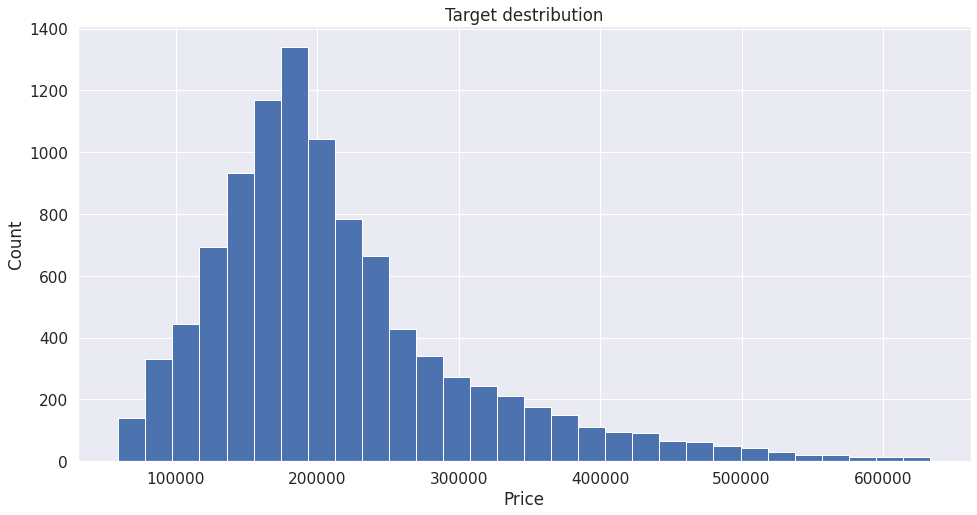

In [1263]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins = 30)
plt.xlabel('Price')
plt.ylabel('Count')

plt.title('Target destribution')
plt.show()

**Количественные переменные**

In [1264]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [1265]:
train_df.select_dtypes(include = 'object').columns.to_list()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### Обработка выбросов


*   Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
*   Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.) 
*   Делать/не делать дополнительную фичу
*   Ничего не делать



**Rooms**

In [1266]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [1267]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | train_df['Rooms'] >= 6, 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [1268]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [1269]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare**

In [1270]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [1271]:
train_df['KitchenSquare'].quantile(0.975), train_df['KitchenSquare'].quantile(0.025)

(13.0, 0.0)

In [1272]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(0.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [1273]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**Square**

In [1274]:
train_df['Square'].sort_values()

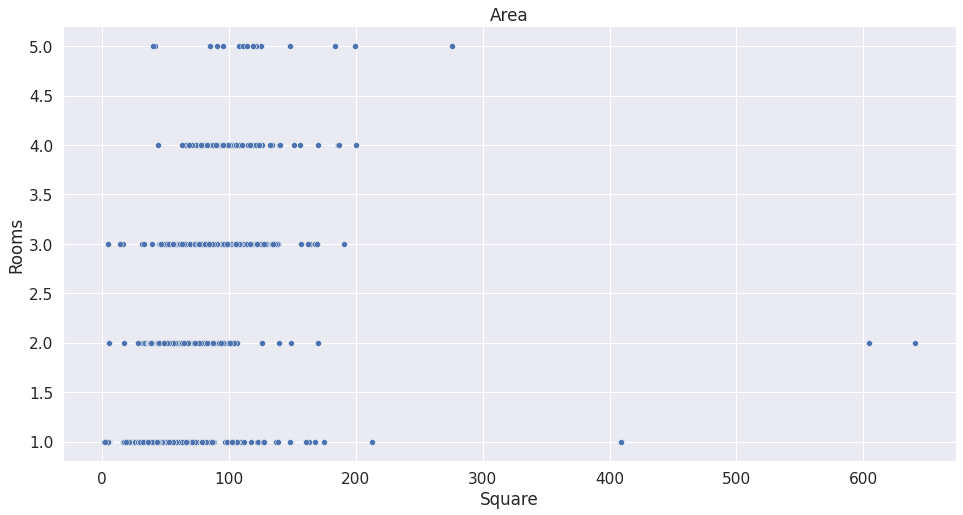

In [1348]:
plt.figure(figsize = (16, 8))

sns.scatterplot(x = train_df['Square'], y = train_df['Rooms'])
plt.xlabel('Square')
plt.ylabel('Rooms')

plt.title('Area')
plt.show()

In [1276]:
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] < 14), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] > 250), 'Square_outlier'] = 1
train_df.head()

In [1277]:
#train_df.loc[train_df['Square'] < 14, 'Square'] = 14
#train_df.loc[train_df['Square'] > 250, 'Square'] = 250

In [1278]:
#plt.figure(figsize = (16, 8))

#sns.scatterplot(x = train_df['Square'], y = train_df['Rooms'])
#plt.xlabel('Square')
#plt.ylabel('Rooms')

#plt.title('Area')
#plt.show()

In [1279]:
#train_df['Square'].sort_values()

**HouseFloor, Floor**

In [1280]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [1281]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [1282]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [1283]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['Floor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor_outlier'] = 1

In [1284]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1285]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [1286]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [1287]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [1288]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [1289]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### **Корреляция признаков**

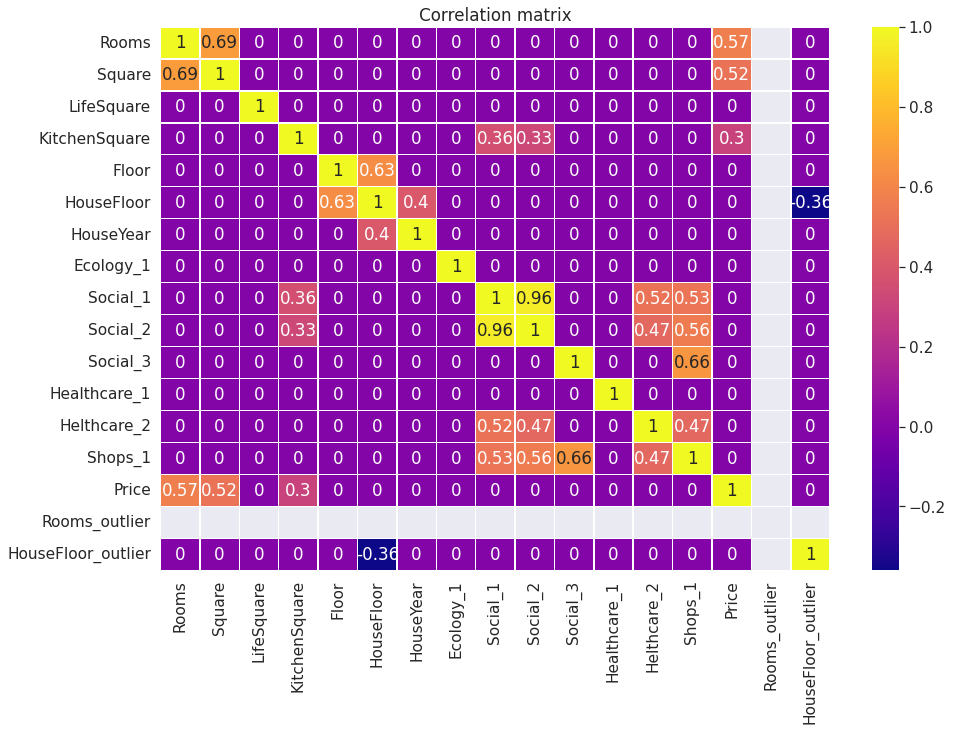

In [1290]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='plasma')

plt.title('Correlation matrix')
plt.show()

Признаки Social_1 и Social_2 очень сильно коррелируют между собой, так что можно избавиться от Social_2

In [1291]:
#train_df.drop('Social_2', axis = 1, inplace = True)

### 3. Обработка пропусков

In [1292]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [1293]:
train_df[['LifeSquare', 'Healthcare_1']].head(10)

,LifeSquare,Healthcare_1
0,NaN,NaN
1,23.169223,1183.0
2,47.671972,240.0
3,NaN,NaN
4,38.562517,NaN
5,47.103833,2078.0
6,21.772930,80.0
7,32.893256,176.0
8,44.628132,NaN
9,75.085125,540.0


**LifeSquare**

In [1294]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())

train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [1295]:
train_df.drop('Healthcare_1', axis = 1, inplace = True)

### Подготовка исходных данных

In [1296]:
class DataPrepocessing():
  def __init__(self):
    self.medians = None
    self.Kitchen_square_quantile = None

  def fit(self, X):
    'Сохранение статистик'
    self.medians = X.median()
    self.Kitchen_square_quantile = X['KitchenSquare'].quantile(0.975)

  def transform(self, X):
    'Трансформация данных'

    #Rooms
    X['Rooms_outlier'] = 0
    X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

    X.loc[X['Rooms'] == 0, 'Rooms'] = 1
    X.loc[X['Rooms'] >= 6, 'Rooms'] = X['Rooms'].median()

    #Square
    X['Square_outlier'] = 0
    X.loc[(X['Square'] < 14), 'Square_outlier'] = 1
    X.loc[(X['Square'] > 250), 'Square_outlier'] = 1

    #X.loc[X['Square'] < 14, 'Square'] = 14
    #X.loc[X['Square'] > 250, 'Square'] = 250

    #KitchenSquare
    condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.Kitchen_square_quantile)
    X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
    X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

    #HouseFloor, Floor
    X['HouseFloor_outlier'] = 0
    X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
    X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

    X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']

    floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
    X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

    #HouseYear
    current_year = datetime.now().year

    X['HouseYear_outlier'] = 0
    X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
    X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

    #Healthcare1
    if 'Healthcare_1' in X.columns:
      X.drop('Healthcare_1', axis = 1, inplace = True)

    #Social_2
    #if 'Social_2' in X.columns:
      #X.drop('Social_2', axis = 1, inplace = True)


    #LifeSquare
    X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
    condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())

    X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

    X.fillna(self.medians, inplace = True)

    return X

### 4. Построение новых признаков

**Dummies**

In [1297]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDictrictLarge**

In [1298]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns = {'index' : 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [1299]:
train_df = train_df.merge(district_size, on='DistrictId', how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


In [1300]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [1301]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [1302]:
#med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceByDistrict'})
#med_price_by_district.head(10)

In [1303]:
#train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how = 'left')
#train_df.head()

**MedPriceBySquare**

In [1304]:
train_df['Square//20'] = train_df['Square']//20
train_df['Square//20'].unique()

array([ 5.,  1.,  3.,  2.,  4.,  0.,  6.,  9., 30.,  7.,  8., 10., 13.,
       20., 32.])

In [1305]:
med_price_by_square = train_df.groupby(['Square//20', 'Rooms'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceBySquare'})
med_price_by_square.tail(10)

,Square//20,Rooms,MedPriceBySquare
39,8.0,4.0,531049.721966
40,9.0,3.0,338644.075979
41,9.0,4.0,381858.351310
42,9.0,5.0,484277.017214
43,10.0,1.0,302211.260887
44,10.0,4.0,528560.506016
45,13.0,5.0,455264.882666
46,20.0,1.0,90470.430830
47,30.0,2.0,187717.242538
48,32.0,2.0,133529.681562


**MedPriceByFloorYear**

In [1306]:
def floor_to_cat(X):
    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & X['Floor'] <= 5, 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & X['Floor'] <= 9, 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & X['Floor'] <= 15, 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins = bins, labels = False)

    X['floor_cat'].fillna(-1, inplace = True)

    return X

def year_to_cat(X):
    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6

    return X

def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins = bins, labels = False)

    X['year_cat'].fillna(-1, inplace = True)

    return X

In [1307]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins = bins, labels = False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [1308]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins = bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [1309]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square//20,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,5.0,6,4
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,1.0,3,4
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,3.0,4,4
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,2.0,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,3.0,3,5


In [1310]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,4,343812.494282
1,2,4,509182.957515
2,3,4,185095.352549
3,3,5,173945.210796
4,4,4,225281.842554


In [1311]:
train_df = train_df.merge(med_price_by_floor_year, on = ['year_cat', 'floor_cat'], how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square//20,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,5.0,6,4,171750.118145
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,1.0,3,4,185095.352549
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,3.0,4,4,225281.842554
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,2.0,3,4,185095.352549
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,3.0,3,5,173945.210796


In [1312]:
class FeatureGenerator():
  'Генерация новых фич'

  def __init__(self):
    self.DistrictId_counts = None
    self.binary_to_numbers = None
    self.med_price_by_square = None
    self.med_price_by_floor_year = None
    self.house_year_max = None
    self.floor_max = None

  def fit(self, X, y = None):
    X = X.copy()

    #Binary features
    self.binary_to_numbers = {'A': 0, 'B': 1}

    #DistrictId
    self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns = {'index' : 'DistrictId', 'DistrictId': 'DistrictSize'})

    #TargetEncoding
    ## District, Rooms
    df = X.copy()

    #if y is not None:
      #df['Price'] = y.values

      #self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceByDistrict'})
      #self.med_price_by_district_median =  self.med_price_by_district['MedPriceByDistrict'].median()

    ##Square, Rooms
    if y is not None:
      df['Price'] = y.values

      df['Square//20'] = df['Square'] // 20
      self.med_price_by_square = df.groupby(['Square//20', 'Rooms'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceBySquare'})
      self.med_price_by_square_median =  self.med_price_by_square['MedPriceBySquare'].median()

    ##floor, year
    if y is not None:
      self.floor_max = df['Floor'].max()
      self.house_year_max = df['HouseYear'].max()
      df["Price"] = y.values
      df = self.floor_to_cat(df)
      df = self.year_to_cat(df)
      self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceByFloorYear'})
      self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
    
  def transform(self, X):

    #Binary features
    X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
    X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
    X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

    #DistrictId, IsDistrictLarge
    X = X.merge(self.district_size, on = 'DistrictId', how = 'left')

    X['new_district'] = 0
    X.loc[X['DistrictSize'].isna(), 'new_district'] = 1

    X['DistrictSize'].fillna(5, inplace = True)
    X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

    #More categorical features
    X = self.floor_to_cat(X)
    X = self.year_to_cat(X)

    #Target encoding
    #if self.med_price_by_district is not None:
      #X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how = 'left')
      #X.fillna(self.med_price_by_district_median, inplace = True)

    if med_price_by_floor_year is not None:
      X = X.merge(self.med_price_by_floor_year, on = ['year_cat', 'floor_cat'], how = 'left')
      X.fillna(self.med_price_by_floor_year_median, inplace = True)

    if self.med_price_by_square is not None:
      X['Square//20'] = X['Square'] // 20
      X = X.merge(self.med_price_by_square, on=['Square//20', 'Rooms'], how = 'left')
      X.fillna(self.med_price_by_square_median, inplace = True)

    return X

  def floor_to_cat(self, X):
    bins = [0, 3, 5, 9, 15, self.floor_max]
    X['floor_cat'] = pd.cut(X['Floor'], bins = bins, labels = False)

    X['floor_cat'].fillna(-1, inplace = True)

    return X

  def year_to_cat(self, X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
    X['year_cat'] = pd.cut(X['HouseYear'], bins = bins, labels = False)

    X['year_cat'].fillna(-1, inplace = True)

    return X

### 5. Отбор признаков

In [1313]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'Square//20',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [1314]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
                 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
 

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'IsDistrictLarge', 'year_cat', 'floor_cat', 'MedPriceBySquare', 'MedPriceByFloorYear', 'Square_outlier']

target_name = 'Price'

### 6. Разбиение на train и test

In [1315]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns = target_name)
y = train_df[target_name]

In [1316]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 21)

In [1317]:
preprocessor = DataPrepocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [1318]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,4378,0,1,1,B,0,0,0,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,629,1,0,0,A,0,0,0,0,0
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,1892,0,0,1,B,0,0,0,0,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,475,0,0,0,B,0,0,0,0,0
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,...,7715,4,0,6,B,0,0,0,0,1


In [1319]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [1320]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByFloorYear,Square//20,MedPriceBySquare
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,0,76.0,0,0,1.0,2,190191.162077,1.0,157562.014801
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,164.0,0,1,2.0,5,179449.269388,2.0,149577.770147
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,0,1,580.0,0,1,4.0,2,173934.865013,2.0,204259.631582
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,372.0,0,1,0.0,2,179485.931037,2.0,224094.091545
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,...,0,1,65.0,0,0,2.0,2,191991.803903,2.0,149577.770147


In [1321]:
len(new_feature_names)

10

In [1322]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [1323]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели

In [1324]:
!pip install lightautoml

**Обучение**

In [1325]:
#rf_model = RandomForestRegressor(random_state = 21, criterion = 'mse')
#rf_model.fit(X_train, y_train)

**Оценка модели**

In [1326]:
#y_train_preds = rf_model.predict(X_train)
#y_test_preds = rf_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс валидация**

In [1327]:
#cv_score = cross_val_score(rf_model, X_train, y_train, scoring = 'r2', cv = KFold(n_splits = 5, shuffle = True, random_state = 21))
#cv_score

In [1328]:
#cv_score.mean()

**Важность признаков**

In [1329]:
#feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns = ['feature_name', 'importance'])
#feature_importances.sort_values(by = 'importance', ascending = False)

### 8. Прогнозирование на тестовом датасете

In [1330]:
#test_df.shape

In [1331]:
#submit = pd.read_csv('/content/drive/MyDrive/Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn/LAST/rf_submit.csv')
#submit.head()

In [1332]:
#predictions = rf_model.predict(test_df)
#predictions

In [1333]:
#submit['Price'] = predictions
#submit.head()

In [1334]:
#submit.to_csv('rf_submit_my.csv', index = False)

### **Light Auto ML**

In [1335]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error, rmsle, r2_score

In [1336]:
TARGET_NAME = target_name

In [1337]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPrepocessing()
preprocessor.fit(train_df)

X_train = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

feature_gen = FeatureGenerator()
feature_gen.fit(X_train, X_train[TARGET_NAME])

X_train = feature_gen.transform(train_df)
test_df = feature_gen.transform(test_df)

In [1338]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByFloorYear,Square//20,MedPriceBySquare
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,0,104.0,0,1,1.0,2,188641.370170,1.0,156682.339687
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,247.0,0,1,2.0,5,174214.269556,2.0,149720.836945
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,0,1,851.0,0,1,4.0,2,173945.210796,2.0,203932.816893
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,565.0,0,1,0.0,2,179600.658613,2.0,226015.052207
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,...,0,1,114.0,0,1,2.0,2,192837.895788,2.0,149720.836945


In [1339]:
TASK = Task('reg', loss = 'mse', metric = rmsle, greater_is_better = False)
TIMEOUT = 300000
N_THREADS = 4 #Количество потокв
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'Price'
TEST_SIZE = 0.2

In [1340]:
roles = {'target': TARGET_NAME, 'drop': ['Id']}

In [1341]:
automl_model = TabularAutoML(task = TASK,
                             timeout = TIMEOUT,
                             cpu_limit = N_THREADS,
                             gpu_ids = 'all',
                             reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                             general_params = {'use_algos': [['lgb_tuned', 'cb_tuned', 'cb'], ['lgb_tuned', 'cb']]},
                             tuning_params = {'max_tuning_iter': 10},
                             )
# LAMA use_algos

In [1342]:
oof_pred = automl_model.fit_predict(X_train, roles = roles)

In [1343]:
X_train.shape

(10000, 32)

In [1344]:
test_df['Price'] = automl_model.predict(test_df).data

In [1345]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByFloorYear,Square//20,MedPriceBySquare,Price
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,104.0,0,1,1.0,2,188641.370170,1.0,156682.339687,165517.875000
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,247.0,0,1,2.0,5,174214.269556,2.0,149720.836945,119449.109375
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,1,851.0,0,1,4.0,2,173945.210796,2.0,203932.816893,135177.656250
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,565.0,0,1,0.0,2,179600.658613,2.0,226015.052207,119474.437500
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,...,1,114.0,0,1,2.0,2,192837.895788,2.0,149720.836945,184535.781250


In [1346]:
test_df.to_csv('submission_LAMA_test_11.csv', columns = ['Id', 'Price'], index = False)

In [1347]:
#test 1 - clip Square - 0.75508 (-0.00009)
#test 2 - drop Social_2 - 0.74908 (-0.00609)
#test 3 - добавил lgb - 0.74783 (-0.0073)
#test 4 - убрал lgb, добавил Square_outlier, сделал 3 уровень AutoML - 0.74000 (-0.01513)
#test 6 - новый признак MedPriceBySquare - 0.00457
#test 7 - удалил признак MedPriceByDistrict - Score: 0.00293
#test 9 - пересчитал MedPriceBySquare(неправильно сделал сначала) - 0.75392
#test 10 - исправил косяки - Score: 0.75447
#test 11 - вернул Social_2, не делал clip Square - Score: 0.75599 (+0,00086) ПОБЕДА! 
#ИТОГ - для победы пригодилось:
        #1 - новый признак Square_outlier
        #2 - замена MedPriceByDistrict на MedPriceBySquare